## Setup Environment and Load Datasets

In [1]:
import polars as pl
from argmap.dataModel import Summary, Comments, Topics, HierarchicalTopics, Arguments, DataModel, Votes

from dotenv import load_dotenv
load_dotenv()

# this allows categorical data from various sources to be combined and handled gracefully; performance cost is acceptable
pl.enable_string_cache()

from IPython.display import display_markdown

In [21]:
DATASET = 'american-assembly.bowling-green'
# DATASET = 'scoop-hivemind.biodiversity'
# DATASET = 'scoop-hivemind.freshwater'
# DATASET = 'scoop-hivemind.taxes'
# DATASET = 'scoop-hivemind.ubi'
# DATASET = 'scoop-hivemind.affordable-housing'
# DATASET = 'london.youth.policing'
# DATASET = 'canadian-electoral-reform'
# DATASET = 'brexit-consensus'
# DATASET = 'ssis.land-bank-farmland.2rumnecbeh.2021-08-01'

summary = Summary(DATASET)
comments = Comments(DATASET).load_from_csv()

moderationResults = []

for i in range(1, 10):
    moderationResult = DataModel(DATASET, f'moderation-results-{i}').load_from_parquet()
    moderationResultDf = (
        moderationResult
        .join(comments.df.select('commentId', 'moderated'), on='commentId')
        .with_columns(correct=pl.col('languageModelModerated') == pl.col('moderated'))
        .sort('commentId')
    )

    moderationResults.append(moderationResultDf)

display_markdown(f"""
### Dataset: {DATASET}
#### {summary.topic}
#### {summary.get('conversation-description')}
#### Full Report: [{summary.url}]({summary.url})
""", raw=True)



### Dataset: american-assembly.bowling-green
#### Improving Bowling Green / Warren County
#### What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?
#### Full Report: [https://pol.is/9wtchdmmun](https://pol.is/9wtchdmmun)


## Evaluation Metrics

### Accuracy
Since our task is multi-label classification, we define this as the dot product of true and predicted labels divided by the number of labels. This depicts the alignment of model's predictions with the ground truth. It is the sum of true positive and true negative minus false positive and false negative predictions while ignoring the UNSURE predictions. We reward the model for a correct prediction, penalize for an incorrect prediction, and do not reward or penalize an UNSURE prediction. The higher the dot product, the better the model's performance.

### Precision
Proportion of predicted REJECT statements that were correctly predicted. This drops significantly if the false positive rate increases. We prefer a high precision in identifying spam. Defined as $\frac{TP}{TP + FP}$.

### Unsure Rate
Measure of how often the model selects UNSURE instead of rendering a decision. We prefer this over false positives.

### False Positive Rate
Measure of a model's rate of falsely rejecting a statement. We prefer false negatives in identifying spam, since there is more harm done by falsely rejecting a legitimate statement than by inadvertently allowing a spam statement. Lower is better.

In [22]:
import numpy as np


def calculate_metrics(true_labels, pred_labels):
    true_labels = true_labels.astype(int)
    pred_labels = pred_labels.astype(int)

    tp = np.sum((true_labels == -1) & (pred_labels == -1))
    tn = np.sum((true_labels == 1) & (pred_labels == 1))
    fp = np.sum((true_labels == 1) & (pred_labels == -1))
    fn = np.sum((true_labels == -1) & (pred_labels == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    # f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fp + fn > 0 else 0
    fpr = fp / (fp + tn)
    unsure = np.sum(pred_labels == 0) / len(pred_labels)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'unsure': unsure
    }

## Performance Metrics across Experimental Configurations

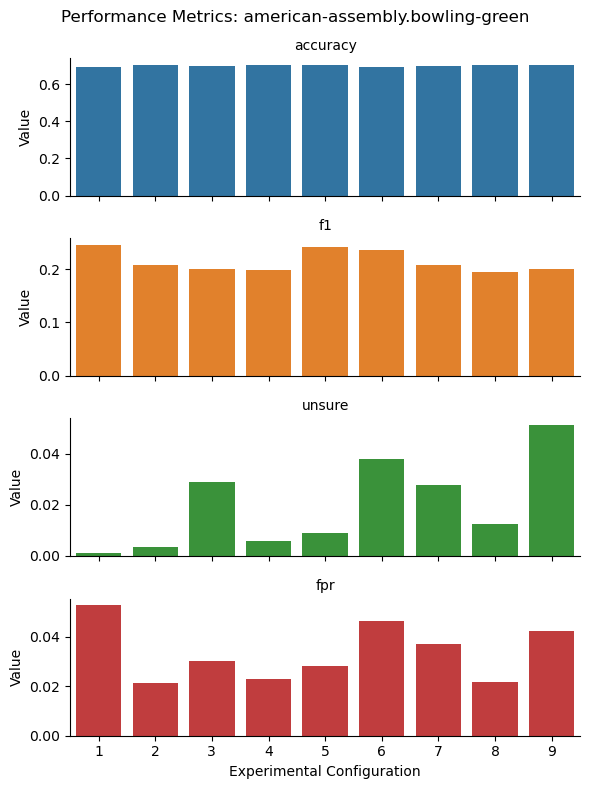

In [23]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_config_metrics(comments, moderationResults, title: str = None):
    true_labels = comments.df.sort(
        'commentId').get_column('moderated').to_numpy()

    metrics_list = []

    for i, moderationResultDf in enumerate(moderationResults, 1):
        pred_labels = moderationResultDf.get_column(
            'languageModelModerated').to_numpy()
        metrics = calculate_metrics(true_labels, pred_labels)
        metrics['config'] = i
        metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list)

    metrics_long_df = pd.melt(
        metrics_df,
        id_vars=['config'],
        var_name="Metric",
        value_name="Value",
        value_vars=['accuracy', 'f1', 'unsure', 'fpr'])

    g = sns.catplot(
        data=metrics_long_df,
        x='config',
        y='Value',
        hue='Metric',
        kind='bar',
        row='Metric',
        height=2,
        aspect=3,
        sharey=False,
        legend=False,
    )

    # for ax in g.axes.flat:
    #   ax.grid(True)

    g.set_titles("{row_name}")
    g.set_axis_labels("Experimental Configuration", "Value")
    if title:
        g.figure.suptitle(title)
    g.figure.tight_layout()

    plt.show()

plot_config_metrics(comments, moderationResults, title=f'Performance Metrics: {DATASET}')

## Results

In the first four experiments, we used a simple technique that starts with classifying each comment as ACCEPT, UNSURE or REJECT. In the next four, we classified among multiple options and introduce more complex reasoning techniques.

Overall, use of examples slightly improved results. Switching to a multi-label classification technique caused significant improvement. Chain of thought reasoning saw a decline in accuracy but made the model less certain about its predictions, which allows for more nuanced decision making.

In [5]:
def plot_confusion_matrix(true_labels, pred_labels, ax):
    labels_captions = ['REJECT', 'UNSURE', 'ACCEPT']
    cm = confusion_matrix(true_labels, pred_labels, labels=[-1, 0, 1])

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap='crest',
        xticklabels=labels_captions,
        yticklabels=labels_captions,
        cbar=False,
        ax=ax
    )
    ax.set_title('Confusion Matrix')
    ax.set_ylabel('Actual labels')
    ax.set_xlabel('Predicted labels')


def plot_barchart(moderationResult, ax):
    df = (
        moderationResult
        .filter(pl.col('languageModelModerated') < 0)
        .with_columns(pl.col('classification').cast(pl.Utf8))
        .group_by('classification', 'correct')
        .agg(
            pl.count('commentId').alias('count')
        )
        .sort('classification')
        .to_pandas()
    )
    red = sns.color_palette("hls")[0]
    green = sns.color_palette("hls")[2]
    sns.barplot(
        data=df,
        x='classification',
        y='count',
        hue='correct',
        hue_order=[True, False],
        palette={True: green, False: red},
        width=0.5,
        legend=False,
        alpha=0.7,
        dodge=True,
        ax=ax,
    )
    ax.set_xlabel('Predicted Reason for Rejection')
    ax.set_ylabel('Count')

    ax.set_title('Classification Distribution')


def plot_dataset(comments, moderationResult, title: str = None):
    figure, axs = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[2, 3])

    true_labels = comments.df.sort(
        'commentId').get_column('moderated').to_numpy()
    pred_labels = moderationResult.sort('commentId').get_column(
        'languageModelModerated').to_numpy()

    plot_confusion_matrix(true_labels, pred_labels, axs[0])
    plot_barchart(moderationResult, axs[1])

    if title:
        plt.suptitle(title)

    plt.tight_layout()

    plt.show()
    metrics = calculate_metrics(true_labels, pred_labels)

    print(f"""\
    Accuracy: \t{round(metrics['accuracy'], 4)}
    Precision: \t{round(metrics['precision'], 4)}
    UnsureRate:\t{round(metrics['unsure'], 4)}
    FPR: \t{round(metrics['fpr'], 4)}
    """)

### Configuration 1: Baseline Model

We have the model classify the comments based on given instructions. We do not provide any examples or reasoning techniques. When the model rejects a comment, we ask it to select a reason from SPAM or COMPLEX.

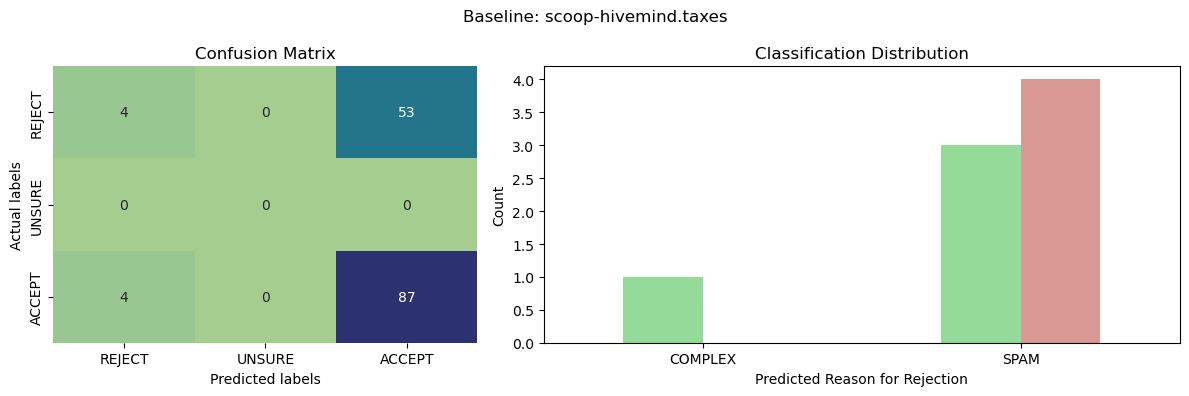

    Accuracy: 	0.6149
    Precision: 	0.5
    UnsureRate:	0.0
    FPR: 	0.044
    


In [6]:
plot_dataset(comments, moderationResults[0], title=f"Baseline: {DATASET}")

### Configuration 2: Adding Examples

We add a set of examples to the language model context before asking it to classify the comments.

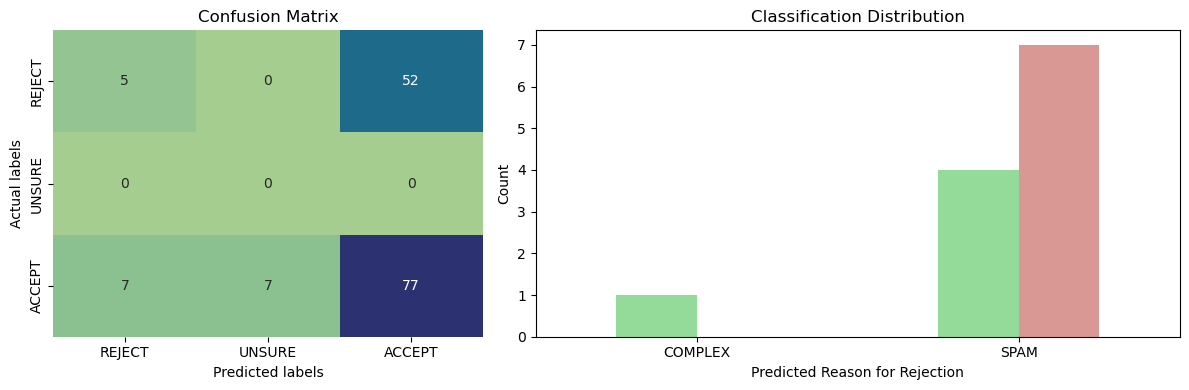

    Accuracy: 	0.5816
    Precision: 	0.4167
    UnsureRate:	0.0473
    FPR: 	0.0833
    


In [7]:
plot_dataset(comments, moderationResults[1])

### Configuration 3: Second-Thought Reasoning

Here, we introduce a second-thought reasoning technique. We do not provide examples to the language model, but if it rejects a comment, we ask it for a reason and then allow it to change the decision from REJECT to UNSURE.

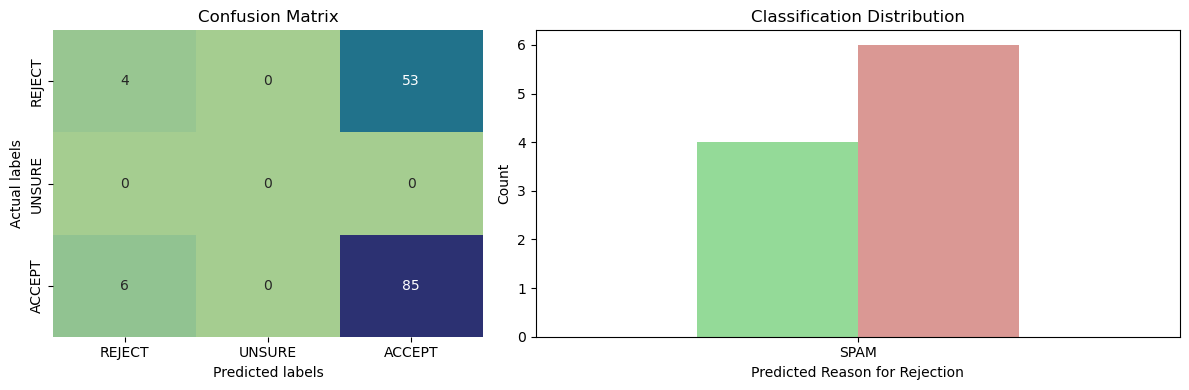

    Accuracy: 	0.6014
    Precision: 	0.4
    UnsureRate:	0.0
    FPR: 	0.0659
    


In [8]:
plot_dataset(comments, moderationResults[2])

### Configuration 4: Second-Thought Reasoning and Examples

In this experiment, we enable examples and also use the second-thought reasoning technique.

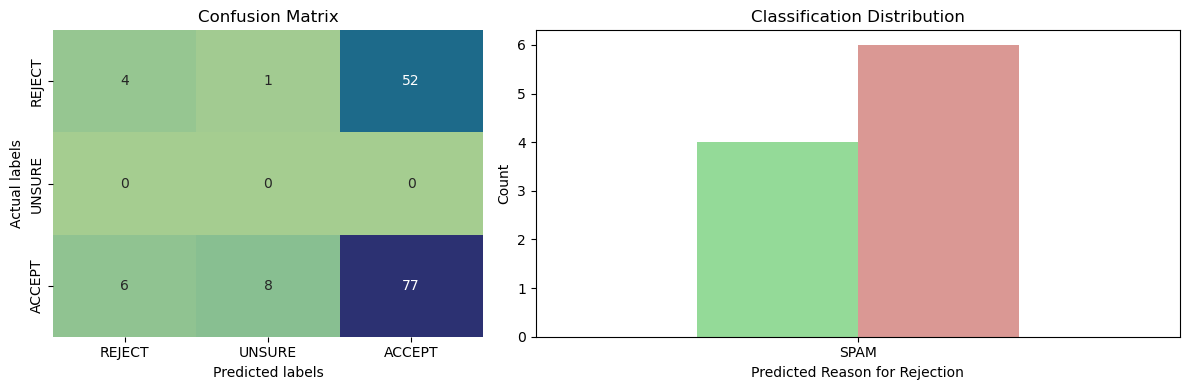

    Accuracy: 	0.5827
    Precision: 	0.4
    UnsureRate:	0.0608
    FPR: 	0.0723
    


In [9]:
plot_dataset(comments, moderationResults[3])

### Configuration 5: Multi-Label Classification

We introduce a multi-label classification task, where the model can classify a comment as ACCEPT, UNSURE, SPAM, IRRELEVANT, UNPROFESSIONAL, SCOPE or COMPLEX. We provide it a set of instructions that describe each label, and also specify an output format to have the model follow the instructions more closely.

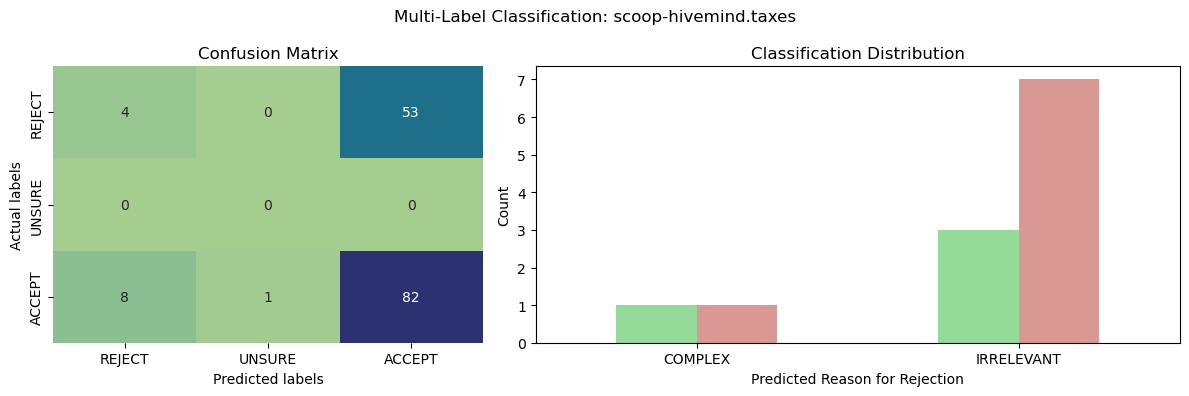

    Accuracy: 	0.585
    Precision: 	0.3333
    UnsureRate:	0.0068
    FPR: 	0.0889
    


In [10]:
plot_dataset(comments, moderationResults[4], title=f"Multi-Label Classification: {DATASET}")

### Configuration 6: Multi-Label Classification with Thought Statement

In this experiment, we use chain-of-thought reasoning ask the model for its thought on each comment before classifying it. While this is siginificantly slower, it allows the model to deliberate on each comment before making a decision.

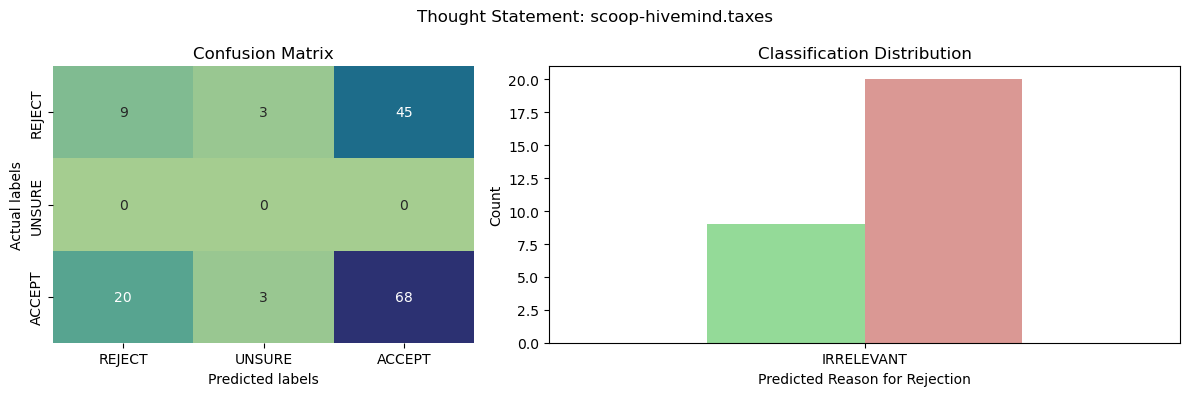

    Accuracy: 	0.5423
    Precision: 	0.3103
    UnsureRate:	0.0405
    FPR: 	0.2273
    


In [11]:
plot_dataset(comments, moderationResults[5], title=f"Thought Statement: {DATASET}")

### Configuration 7: Deconstructing Comments in Multi-Label Classification

Deconstructing each comment into its requisite components might further help improve the analysis and evaluation abilities of the model. While we do not care about the accuracy or agreeability of the posted comments, we do expect either a problem or a potential solution. Also, we want the comment to present a single idea.

In this experiment, introduce a reasoning technique that asks the model for the requisite components of each comment. We ask for the problem identified by the comment, the proposed solution, and the number of ideas introduced by a comment. If neither a relevant problem nor a solution is present, the comment is considered spam. If it introduces more than one idea, we consider it COMPLEX.

After deconstructing the comment, we then ask the model for its thought before making a decision based on whether the comment adds value to the conversation. In this case, we introduce a multi-label classification task, where the model can classify a comment as ACCEPT, UNSURE, SPAM, IRRELEVANT, UNPROFESSIONAL, SCOPE or COMPLEX.



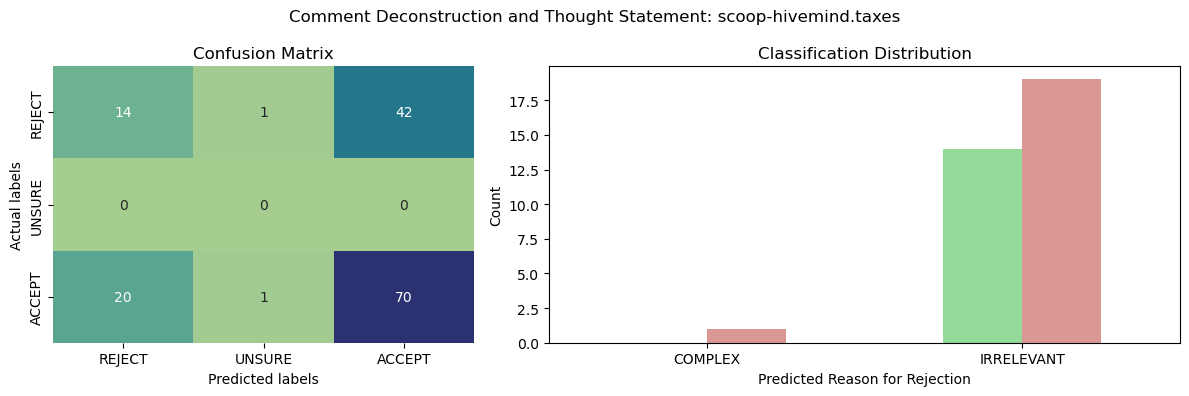

    Accuracy: 	0.5753
    Precision: 	0.4118
    UnsureRate:	0.0135
    FPR: 	0.2222
    


In [12]:
plot_dataset(comments, moderationResults[6], title=f"Comment Deconstruction and Thought Statement: {DATASET}")

### Configuration 8: Multi-Label Classification with Comment Deconstruction and No Thought Statement

We remove the thought statement and only use the deconstruction technique from the previous experiment to study its effect.

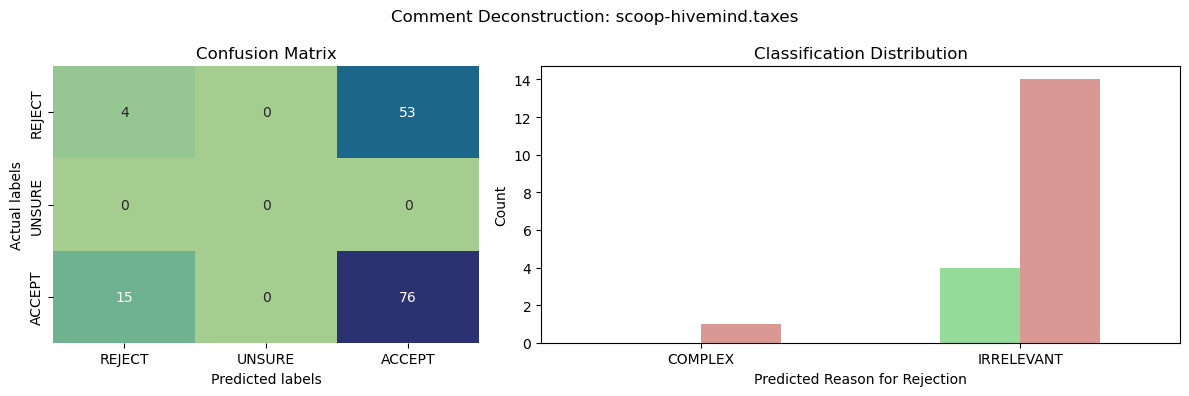

    Accuracy: 	0.5405
    Precision: 	0.2105
    UnsureRate:	0.0
    FPR: 	0.1648
    


In [13]:
plot_dataset(comments, moderationResults[7], title=f"Comment Deconstruction: {DATASET}")

### Configuration 9: Three-Label Classification with Comment Deconstruction and Thought Statement

We use the same reasoning technique as in Experiment 7, but we revert to a simpler classification task, where we ask the model to classify between ACCEPT, UNSURE, and REJECT.

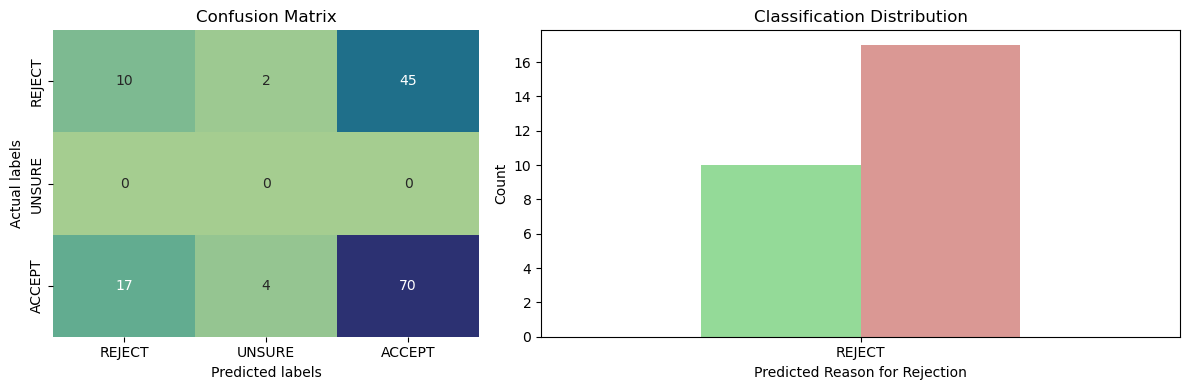

    Accuracy: 	0.5634
    Precision: 	0.3704
    UnsureRate:	0.0405
    FPR: 	0.1954
    


In [14]:
plot_dataset(comments, moderationResults[8])

The above results might be improved through context reset, which bounds the context memory and allows the model to focus on the current comment. We will test this hypothesis in the following test.

The above run took about 6 seconds per comment on H100 GPU, which is about 90 minutes for the entire dataset of ~900 comments. This is computationally expensive but appears to yield significantly better results.

## Further Analysis

### Prompt Refinements

REJECT:

- does not provide a solution or mention a problem
- informal and colloquial
- relevant to posted question
- The comment introduces multiple ideas, but they are all related to improving the area.
- if no problem identified, say so
- if no solution identified, say so
- Cannot be addressed within the scope of original question.


> Comment: Bowling Green needs a homeless shelter. (Moderated: -1)
> - PROBLEM: Bowling Green lacks a homeless shelter.
> - ACTION: Establish a homeless shelter in Bowling Green.
> - THOUGHT: The comment identifies a problem and proposes a solution.

No problem identified - only a solution

> Comment: The driving conditions on the 31-W bypass are very poor and need to be changed. (Moderated: -1)
> - PROBLEM: The driving conditions on the 31-W bypass are very poor.
> - ACTION: Change the driving conditions on the 31-W bypass.
> - THOUGHT: The comment mentions a problem and suggests a solution, so it should be accepted.

No solution identified - only a problem

Comment: Bowling Green should become a Metro. (Moderated: -1)
- PROBLEM: Bowling Green does not have a metro system.
- ACTION: Implement a metro system in Bowling Green.

> Comment: Know who all your neighbors are (Moderated: -1)
> - PROBLEM: Lack of familiarity with neighbors.
> - ACTION: Encourage getting to know neighbors.
> - IDEAS: 1
> - THOUGHT: The comment mentions a problem and suggests a solution.

Cannot be addressed within the scope of original question.

### Future Work

We should consider the effect of `temperature` on spam classification. For the above experiment, we kept `temperature = 0` to limit randomness and allow reproducibility of results. However, a higher temperature might allow the model to explore more options and improve its reasoning abilities, especially when employing the chain-of-thought reasoning approach.

<!-- Context Reset: In the first iteration, we write the instructions to the context and then ask the model to moderate one comment at a time. After each decision, the comment is removed and the next one is placed in the context. This bounds the context memory, speeds up the computation, and improves the model's ability to follow instructions. -->